## Predicting outcomes by splitting data

In [1]:
import pandas as pd

filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/tennis.feather'
tennis = pd.read_feather(filename)

In [2]:
X = tennis[['outlook', 'temperature', 
            'humidity', 'wind']]
X = pd.get_dummies(X)
y = tennis.play

In [3]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

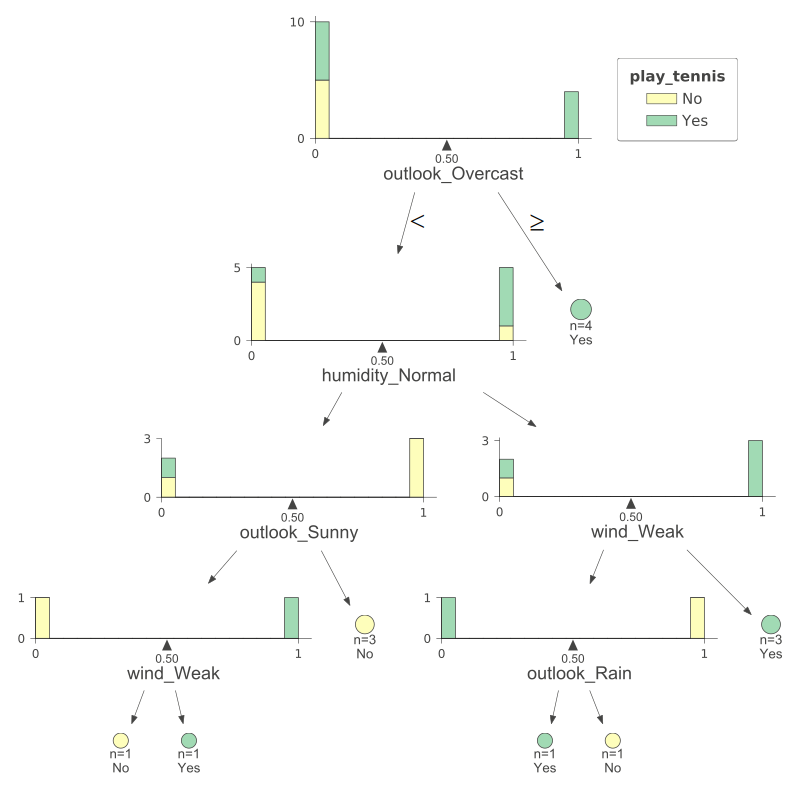

In [4]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(dt, X, y,
               target_name='play_tennis',
               feature_names=X.columns, 
               class_names=["No", "Yes"],
               scale=2.0)  

viz

## Pruning overgrown trees

In [5]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/titanic.feather'
titanic = pd.read_feather(filename)

In [6]:
from sklearn.model_selection import train_test_split

X = titanic.iloc[:,:-1]
y = titanic.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    shuffle=True)

In [7]:
dt = DecisionTreeClassifier(min_samples_split=5)
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)

print(f"test accuracy: {accuracy:0.3}")

test accuracy: 0.774


In [8]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

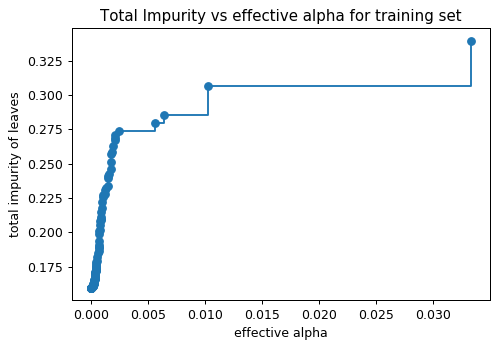

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=90)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [10]:
best_pruning = list()
for ccp_alpha in ccp_alphas:
    if ccp_alpha > 0:
        dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        dt.fit(X_train, y_train)
        best_pruning.append([ccp_alpha, dt.score(X_test, y_test)])
        
best_pruning = sorted(best_pruning, key=lambda x:x[1], reverse=True)

In [11]:
best_ccp_alpha = best_pruning[0][0]
dt = DecisionTreeClassifier(random_state=0, 
                            ccp_alpha=best_ccp_alpha)
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)

print(f"test accuracy: {accuracy:0.3}")

test accuracy: 0.805


In [12]:
print("Number of nodes in the last tree is: {} with ccp_alpha: {:0.3}"
      .format(dt.tree_.node_count, best_ccp_alpha))

Number of nodes in the last tree is: 13 with ccp_alpha: 0.0025


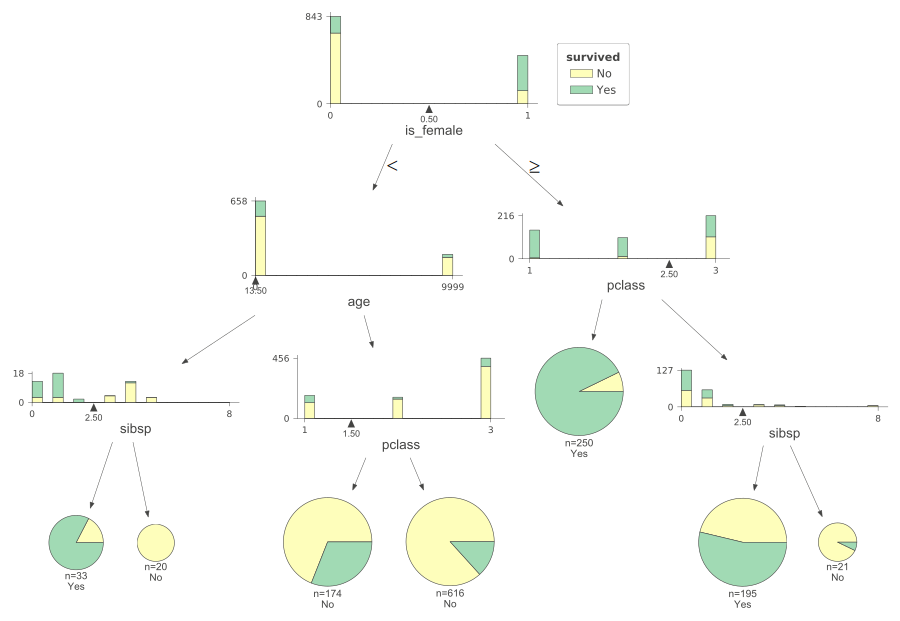

In [13]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(dt, X, y,
               target_name='survived',
               feature_names=X.columns, 
               class_names=["No", "Yes"],
               scale=1.5)  

viz

# Taking a Probabilistic Turn

## Understanding Naïve Bayes

In [14]:
pd.crosstab(tennis.outlook, 
            tennis.play.replace({0:'NO', 1:'YES'}))

play,NO,YES
outlook,,
Overcast,0,4
Rain,2,3
Sunny,3,2


In [15]:
pd.crosstab(tennis.outlook, 
            tennis.play.replace({0:'NO', 1:'YES'}),
            normalize='columns')

play,NO,YES
outlook,,
Overcast,0.0,0.444444
Rain,0.4,0.333333
Sunny,0.6,0.222222


In [16]:
prob_outcomes = tennis.play.value_counts(sort=False, 
                                         normalize=True)
outlook = pd.crosstab(tennis.outlook, tennis.play, 
                      normalize='columns')
temperature = pd.crosstab(tennis.temperature, tennis.play, 
                          normalize='columns')
humidity =  pd.crosstab(tennis.humidity, tennis.play, 
                        normalize='columns')
wind = pd.crosstab(tennis.wind, tennis.play, 
                   normalize='columns')

In [17]:
proba = prob_outcomes
proba *= outlook.loc["Sunny"] 
proba *= temperature.loc["Mild"]
proba *= humidity.loc["Normal"]
proba *= wind.loc["Weak"]

print(proba)

0    0.006857
1    0.028219
Name: play, dtype: float64


## Estimating response with Naïve Bayes

In [18]:
filename = 'https://github.com/lmassaron/datasets/'
filename += 'releases/download/1.0/spam.feather'
spam = pd.read_feather(filename)

In [19]:
X = spam.iloc[:,:-1]
y = spam.iloc[:, -1]

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB()

preds = cross_val_predict(nb, X, y, cv=5, n_jobs=-1)

In [21]:
from sklearn.metrics import classification_report

cr = classification_report(y_true=y, y_pred=preds, 
                           target_names=['non spam', 'spam'])
print(cr)

              precision    recall  f1-score   support

    non spam       0.89      0.92      0.90      2788
        spam       0.87      0.82      0.84      1813

    accuracy                           0.88      4601
   macro avg       0.88      0.87      0.87      4601
weighted avg       0.88      0.88      0.88      4601

